In [590]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from cleaning_utils import * # import all existing functions from file cleaning.py

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---



## Loading Blight Data

In [620]:
blight = pd.read_csv('../P3_data/Blight_Violations.csv',low_memory=False)

In [621]:
blight.shape

(496335, 36)

In [597]:
train=pd.read_csv('train.csv', encoding='cp1252',low_memory=False)

In [598]:
train.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [599]:
blight_cut = blight[['ticket_id', 'parcelno']]

In [600]:
blight_cut = blight_cut.dropna(subset=['parcelno'])

In [604]:
blight_joined = pd.merge(train, blight_cut, left_on='ticket_id', right_on='ticket_id', how= 'left')

In [605]:
blight_joined.rename({'parcelno': 'parcel_id'}, axis=1, inplace=True)

In [607]:
blight_joined = blight_joined.dropna(subset=['parcel_id'])

In [609]:
blight_joined['parcel_id'] = blight_joined.apply(parse_parcel, axis=1)

In [610]:
blight_joined

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,parcel_id
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,12004359
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,20004897
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,6002481
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,6002480
5,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,CA,908041512,NaN,USA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,16012664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250293,284333,Department of Public Works,"Granberry, Aisha B","AMERICAN INTERNATIONAL ASS. LL, .",15634.0,NOVARA,NaN,72.0,MANGROVE,CHICO,MI,95926,NaN,USA,2011-12-30 14:20:00,2012-01-05 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,0.0,250.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,21022379
250295,284883,Detroit Police Department,"Thornton, Vaughn","clavon, juan",19044.0,CHICAGO,NaN,726.0,bethune,detroit,MI,48202,NaN,USA,2011-12-31 16:15:00,2012-01-18 09:00:00,22-2-88(a),"Failure of owner to keep property, its sidewal...",Not responsible by Dismissal,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,22004203
250296,366178,"Buildings, Safety Engineering & Env Department","Bush, Wesley",MARK JACKSON,8020.0,PURITAN,NaN,251.0,HEYDEN,DETROT,MI,48219,NaN,USA,2006-07-28 14:00:00,2016-10-06 09:00:00,9-1-111,Failure of owner to remove graffiti or maintai...,Not responsible by City Dismissal,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,GRAFFITI TICKET,not responsible by disposition,NaN,16007830
250297,366176,"Buildings, Safety Engineering & Env Department","Bush, Wesley",MARK JACKSON,8020.0,PURITAN,NaN,251.0,HEYDEN,DETROT,MI,48219,N

In [514]:
blight.payment_status.value_counts()

NO PAYMENT DUE             210004
PAID IN FULL                97642
PARTIAL PAYMENT APPLIED      9080
NO PAYMENT APPLIED              2
Name: payment_status, dtype: int64

In [515]:
blight = blight[blight.payment_status == 'PAID IN FULL']

In [516]:
blight.columns

Index(['X', 'Y', 'ticket_id', 'ticket_number', 'agency_name', 'inspector_name',
       'violator_name', 'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'violator_id', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'violation_date', 'ticket_issued_time',
       'hearing_date', 'hearing_time', 'judgment_date', 'violation_code',
       'violation_description', 'disposition', 'clean_up_cost',
       'payment_amount', 'payment_date', 'payment_status', 'collection_status',
       'violation_address', 'parcelno', 'oid', 'geom', 'fine_amount'],
      dtype='object')

In [517]:
# Selecting not important features to drop from DF
columns_to_drop = [
                 'ticket_number',
                 'agency_name',
                 'inspector_name',
                 'violator_name',
                 'violator_id',
                 'mailing_address_str_number',
                 'mailing_address_str_name',
                 'city',
                 'state',
                 'zip_code',
                 'non_us_str_code',
                 'country',
                 'ticket_issued_time',
                 'hearing_date',
                 'hearing_time',
                 'violation_code',
                 'violation_description',
                 'disposition',
                 'clean_up_cost',
                 'payment_amount',
                 'collection_status',
                 'violation_address',
                 'oid',
                 'geom',
                 'fine_amount']

In [518]:
blight = blight.drop(columns=columns_to_drop)

In [519]:
blight.shape

(97642, 11)

-----






## Defining Target Variable Compliance

In [520]:
blight.head()

,X,Y,ticket_id,violation_street_number,violation_street_name,violation_zip_code,violation_date,judgment_date,payment_date,payment_status,parcelno
7,-83.019172,42.339196,18653,2900,JEFFERSON,NaN,2005/01/14 00:00:00+00,2005/02/23 00:00:00+00,2005/02/22 08:43:00+00,PAID IN FULL,11000088.014
11,-82.942097,42.388525,18657,15439,MACK,NaN,2005/01/14 00:00:00+00,2005/02/18 00:00:00+00,2005/03/09 13:33:00+00,PAID IN FULL,21001420.
12,-82.946176,42.371778,18658,14214,JEFFERSON,NaN,2005/01/14 00:00:00+00,2005/02/04 00:00:00+00,2005/02/04 10:19:00+00,PAID IN FULL,21000354.
15,-83.045750,42.335121,18661,1310,BROADWAY,NaN,2005/01/14 00:00:00+00,2005/02/18 00:00:00+00,2007/06/12 00:00:00+00,PAID IN FULL,01004004.
18,-83.044467,42.335210,18664,343,MACOMB,NaN,2005/01/14 00:00:00+00,2005/03/23 00:00:00+00,2007/05/31 00:00:00+00,PAID IN FULL,01000207.


In [521]:
blight.violation_date = pd.to_datetimjudgment_date']).dt.date
blight.payment_date = pd.to_datetime(blight['pe(blight['violation_date']).dt.date
blight.judgment_date = pd.to_datetime(blight['ayment_date']).dt.date

In [522]:
blight.rename({'Y':'lat', 'X':'lon', 'parcelno': 'parcel_id'}, axis=1, inplace=True)
blight = blight.dropna(subset=['parcel_id'])
blight['parcel_id'] = blight.apply(parse_parcel,axis=1)

In [523]:
# Create new column compliance - target variable
blight['compliance'] = blight.apply(compliance, axis=1)

In [524]:
blight.compliance.value_counts(normalize= True)

0    0.667435
1    0.332565
Name: compliance, dtype: float64

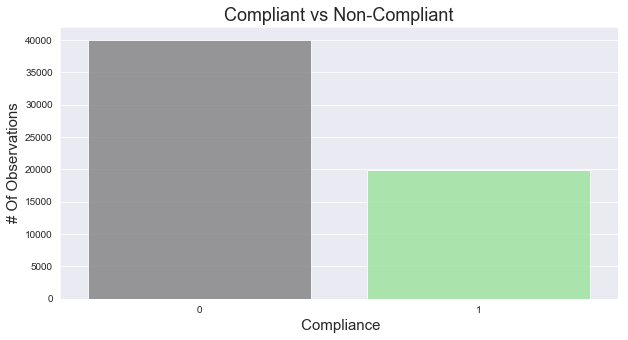

In [525]:
# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(blight['compliance'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Compliant vs Non-Compliant', size = 18)
plt.ylabel('# Of Observations', size =15)
plt.xlabel(' Compliance', size =15)
plt.show()

In [526]:
# applying function coord_bligth
blight['coordinates'] = blight.apply(coord_bligth,axis=1)

In [527]:
blight.to_csv(r'data/Blight.csv', index = False)

----




## Exploring Crime in Neighborhoods with data Reported_Major_Crimes_2011_to_2014

In [528]:
crimes = pd.read_csv('../P3_data/Reported_Major_Crimes_2011_to_2014.csv')

In [529]:
crimes.head()

,ROWNUM,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,NEIGHBORHOOD,CENSUSTRACT,LOCATION,ObjectId
0,1311873,STOLEN VEHICLE,VEHICLE THEFT,24001,2011/01/02 00:00:00+00,0,1103.0,11.0,PERSHING,5066.0,"00 EUREKA/E LANTZ\n(42.4382, -83.0579)",1
1,1311874,AGGRAVATED ASSAULT,AGG/FEL ASSAULT - NON-FAMILY - OTHER WEAPON,13002,2011/01/02 00:00:00+00,11,709.0,7.0,LAFAYETTE PARK,5166.0,"E.LAFAYETTE01800\n(42.3394, -83.0295)",2
2,1311878,LARCENY,"LARCENY - FROM BUILDING (INCLUDES LIBRARY, OFF...",23003,2011/01/02 00:00:00+00,11,1105.0,11.0,OUTER DRIVE VAN DYKE,5051.0,"VANDYKE19900\n(42.4415, -83.0238)",3
3,1311879,LARCENY,LARCENY (OTHER),23007,2011/01/01 00:00:00+00,20,706.0,7.0,CHENE,5188.0,"JOS CAMPAU04100\n(42.3606, -83.0339)",4
4,1311883,STOLEN VEHICLE,VEHICLE THEFT,24001,2011/01/02 00:00:00+00,3,612.0,6.0,WARRENDALE,5457.0,"PIEDMONT06000\n(42.3328, -83.228)",5


In [530]:
crimes = crimes[['LOCATION','CATEGORY','INCIDENTDATE','NEIGHBORHOOD']]

In [531]:
# Using functions extract_lat_crime and extract_long_crime
crimes['lat'] = crimes.LOCATION.map(extract_lat_crime)
crimes['lon'] = crimes.LOCATION.map(extract_long_crime)

In [532]:
crimes['lat'].describe()

count    234978.000000
mean       1833.966961
std       42288.290069
min          39.744700
25%          42.356000
50%          42.391800
75%          42.421300
max      999999.000100
Name: lat, dtype: float64

In [533]:
crimes['lon'].describe()

count    234978.000000
mean       1708.699648
std       42293.597149
min         -84.912300
25%         -83.188300
50%         -83.111700
75%         -83.027100
max      999999.000100
Name: lon, dtype: float64

In [534]:
crimes =  crimes[ (crimes['lat'] < 45) | (crimes['lon'] < 85) ]
crimes['coordinates'] = crimes.apply(coord_bligth, axis=1)
crimes.INCIDENTDATE = pd.to_datetime(crimes['INCIDENTDATE']).dt.date

In [555]:
crimes_count = crimes.groupby('NEIGHBORHOOD').count()

In [556]:
crimes_count['lat'] = crimes.groupby('NEIGHBORHOOD')['lat'].mean()
crimes_count['lon'] = crimes.groupby('NEIGHBORHOOD')['lon'].mean()

In [558]:
crimes_count.head()

,LOCATION,CATEGORY,INCIDENTDATE,lat,lon,coordinates
NEIGHBORHOOD,,,,,,
ARDEN PARK/EAST BOSTON,412,412,412,42.384906,-83.078589,412
ATKINSON-EUCLID,449,449,449,42.378886,-83.083864,449
BAGLEY,2710,2710,2710,42.423409,-83.151066,2710
BALDUCK PARK,2211,2211,2211,42.414952,-82.920932,2211
BARTON MCFARLANE,4282,4282,4282,42.362512,-83.163713,4282


In [559]:
crimes_count.to_csv(r'data/Crimes.csv', index = False)

-----





## Exploring Motor City Mapping

In [423]:
mcm = pd.read_csv('../P3_data/Motor_City_Mapping,_Winter_2013-14_Certified_Results.csv')

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [424]:
mcm.head(3)

,OBJECTID,D3_SurveyParcelID,CityParcelID2013,AddCombo,Address_Number,Address_Direction,Street,Zip,PCount,Blext_ID,User_ID,Reviewer_ID,Time_Surveyed,Updated_At,Status,Photo_URL,Structure,Use_,Condition,Occupancy,Needs_Boarding,Fire,Dumping,Units,Improved,Maintained,PublicUse,Notes,GEOID10_Tract,NAMELSAD10_Tract,GEOID10_Block,NAME10_Block,GeoID10_BG
0,1,01000004.001,01000004.001,201 RANDOLPH,201,,RANDOLPH,48200,1,411094.0,2891.0,3284.0,2014/02/07 17:58:18+00,2014/08/27 15:31:15+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,Parcel contains portion of Detroit-Windsor Tunnel,26163517200,Census Tract 5172,261635172001080,Block 1080,261635172001
1,2,01000004.002L,01000004.002L,159 RANDOLPH,159,,RANDOLPH,48200,1,411082.0,2891.0,3284.0,2014/02/07 17:57:31+00,2014/02/10 18:16:20+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,NaN,26163517200,Census Tract 5172,261635172001082,Block 1082,261635172001
2,3,01000005.002L,01000005.002L,160 E JEFFERSON,160,E,JEFFERSON,,1,411127.0,2891.0,3284.0,2014/02/07 18:01:08+00,2014/02/10 18:15:49+00,1.0,https://wdwot.s3.amazonaws.com/blexts/000/411/...,yes,commercial,good,occupied,no,no,no,NaN,NaN,NaN,NaN,NaN,26163517200,Census Tract 5172,261635172001088,Block 1088,261635172001


In [425]:
mcm.columns

Index(['OBJECTID', 'D3_SurveyParcelID', 'CityParcelID2013', 'AddCombo',
       'Address_Number', 'Address_Direction', 'Street', 'Zip', 'PCount',
       'Blext_ID', 'User_ID', 'Reviewer_ID', 'Time_Surveyed', 'Updated_At',
       'Status', 'Photo_URL', 'Structure', 'Use_', 'Condition', 'Occupancy',
       'Needs_Boarding', 'Fire', 'Dumping', 'Units', 'Improved', 'Maintained',
       'PublicUse', 'Notes', 'GEOID10_Tract', 'NAMELSAD10_Tract',
       'GEOID10_Block', 'NAME10_Block', 'GeoID10_BG'],
      dtype='object')

In [426]:
# Selecting not important features to drop from DF
columns_to_drop = ['OBJECTID',
                 'PublicUse',
                 'D3_SurveyParcelID',
                 'Use_',
                 'Address_Number',
                 'Address_Direction',
                 'Street',
                 'Zip',
                 'PCount',
                 'Blext_ID',
                 'User_ID',
                 'Reviewer_ID',
                 'Time_Surveyed',
                 'Updated_At',
                 'Status',
                 'Photo_URL',
                 'Notes',
                 'GEOID10_Tract',
                 'NAMELSAD10_Tract',
                 'GEOID10_Block',
                 'NAME10_Block',
                 'GeoID10_BG',
                  'Occupancy']

In [427]:

mcm = mcm.drop(columns=columns_to_drop, axis=1)
mcm.rename({'CityParcelID2013': 'parcel_id'}, axis=1, inplace=True)
mcm['parcel_id'] = mcm.apply(parse_parcel,axis=1)
mcm = mcm.dropna(subset= [ 'Condition', 'Needs_Boarding', 'Fire', 'Dumping', 'Maintained'], how='all')


In [428]:

count_id = pd.DataFrame(mcm.groupby('parcel_id')['parcel_id'].count())
count_id = count_id.rename({'parcel_id':'parcel_count'}, axis=1)
count_id = count_id.reset_index()


In [429]:

mcm = pd.merge(mcm, count_id, left_on='parcel_id', right_on='parcel_id')
mcm = mcm[mcm.parcel_count ==1].drop('parcel_count', axis =1)


In [430]:
mcm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355280 entries, 2 to 373211
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   parcel_id       355280 non-null  int64 
 1   AddCombo        355280 non-null  object
 2   Structure       355278 non-null  object
 3   Condition       247393 non-null  object
 4   Needs_Boarding  247313 non-null  object
 5   Fire            247325 non-null  object
 6   Dumping         355239 non-null  object
 7   Units           232539 non-null  object
 8   Improved        108078 non-null  object
 9   Maintained      108031 non-null  object
dtypes: int64(1), object(9)
memory usage: 29.8+ MB


In [431]:
mcm.Dumping.fillna('no', inplace = True)
mcm.Units.fillna('4+ units', inplace = True)
mcm.Fire.fillna('no', inplace = True)
#mcm.Improved.fillna('not_defined', inplace = True)

In [432]:
mcm.dropna(subset=['Condition'], inplace=True)
mcm.Maintained.fillna('unknown', inplace= True)
mcm.Needs_Boarding.fillna('no', inplace=True)

In [611]:
mcm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247393 entries, 2 to 373211
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   parcel_id       247393 non-null  int64 
 1   AddCombo        247393 non-null  object
 2   Structure       247392 non-null  object
 3   Condition       247393 non-null  object
 4   Needs_Boarding  247393 non-null  object
 5   Fire            247393 non-null  object
 6   Dumping         247393 non-null  object
 7   Units           247393 non-null  object
 8   Improved        247393 non-null  object
 9   Maintained      247393 non-null  object
dtypes: int64(1), object(9)
memory usage: 20.8+ MB


In [435]:
mcm.to_csv(r'data/MCM.csv', index = False)




###  Joining MCM and Blight

In [613]:
final_df = pd.merge(blight_joined, mcm, left_on='parcel_id', right_on='parcel_id', how= 'left')

In [614]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151660 entries, 0 to 151659
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   151660 non-null  int64  
 1   agency_name                 151660 non-null  object 
 2   inspector_name              151660 non-null  object 
 3   violator_name               151641 non-null  object 
 4   violation_street_number     151660 non-null  float64
 5   violation_street_name       151660 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  149386 non-null  float64
 8   mailing_address_str_name    151660 non-null  object 
 9   city                        151660 non-null  object 
 10  state                       151596 non-null  object 
 11  zip_code                    151660 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

In [616]:
final_df = final_df.dropna(subset=['compliance'])

In [618]:
final_df

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,parcel_id,AddCombo,Structure,Condition,Needs_Boarding,Fire,Dumping,Units,Improved,Maintained
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,12004359,2900 TYLER,yes,poor,yes,yes,no,4+ units,not_defined,unknown
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,20004897,4311 CENTRAL,yes,good,no,no,no,4+ units,not_defined,unknown
4,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,CA,908041512,NaN,USA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,16012664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,MI,48038,NaN,USA,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,17004863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,MI,48211,NaN,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,15014168,8228 MT ELLIOTT,yes,good,no,no,no,4+ units,not_defined,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151641,285106,Department of Public Works,"Zizi, Josue","LUNDY, ANTONIO R",20009.0,NORTHLAWN,NaN,18715.0,MARLOWE,DETROIT,MI,48235,NaN,USA,2011-12-27 14:50:00,2012-02-03 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,0.0,250.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,16032103,20009 NORTHLAWN,yes,good,no,no,no,1 unit,not_defined,unknown
151649,284650,Department of Public Works,"Lusk, Gertrina","HARDAWAY, WILLIE",15725.0,STEEL,NaN,NaN,P.O. BOX 27125,DETROIT,MI,48227,NaN,USA,2011-12-29 09:50:00,2012-01-09 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,0.0,1130.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0,22022892,15725 STEEL,yes,good,no,no,no,1 unit,not_defined,unknown
151650,285125

------






### Loading and Modifying Parcels Table

In [464]:
parcels = pd.read_csv('../P3_data/Parcels.csv')

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [465]:
parcels.head()

,object_id,parcel_number,ward,address,council_district,zip_code,taxpayer_1,taxpayer_2,taxpayer_street,taxpayer_city,taxpayer_state,taxpayer_zip,property_class,property_class_desc,use_code,use_code_desc,tax_status,total_square_footage,total_acreage,frontage,depth,homestead_pre,nez,is_improved,num_bldgs,total_floor_area,style,year_built,sale_price,sale_date,assessed_value,taxable_value,landmap,related,zoning,subdivision,legal_description
0,1,04000103-4,4,631 W FORT,6,48226,FORT ST PRESBYTERIAN,NaN,631 W FORT ST,DETROIT,MI,48226-3106,201,COMMERCIAL,22650,RELIGIOUS STRUCTURE/USE,RELIGIOUS,20700.0,0.475,150.0,138.0,0.0,NaN,1,5,29399.0,Auditoriums,1876.0,0,1970/01/01 00:00:00+00,0.0,0.0,001,NaN,B5,NaN,S FORT 4 THRU 6BLK 14 WESTERN ADDITION SUB L7 ...
1,2,04003341.,4,624 THIRD,6,48226,ALCORA INC,NaN,624 THIRD,DETROIT,MI,48226,201,COMMERCIAL,22480,BAR,TAXABLE,2309.0,0.053,23.0,100.0,0.0,NaN,1,2,3369.0,Bar Cocktail Lounges,1920.0,147500,2011/05/23 00:00:00+00,210700.0,76557.0,001,24002615.,B5,NaN,"E THIRD N 1/2 7 BLK 14 WESTERN ADD L7 P164 CR,..."
2,3,04003339-40,4,610 THIRD,6,48226,1354 ASSOC LLC,NaN,"333 W. FORT ST., SUITE 1350",DETROIT,MI,48226,202,COMMERCIAL VACANT,22255,PARKING LOT-PAVED,TAXABLE,18382.0,0.422,115.0,163.0,0.0,NaN,0,0,NaN,NaN,NaN,0,1970/01/01 00:00:00+00,791800.0,392894.0,001,NaN,B5,NaN,E THIRD 9-8 S 23 FT OF 7 10BLK 14 MAP OF WESTE...
3,4,04000119.,4,541 W LAFAYETTE,6,48226,"SHEHAN, JOSEPH & LOUISE & WAYNE","KEARNEY, GAIL & GARCEAU, LYLA",3370 ROCKYCRUST,ROCHESTER HILLS,MI,48306,202,COMMERCIAL VACANT,22255,PARKING LOT-PAVED,TAXABLE,13983.0,0.321,100.0,140.0,0.0,NaN,0,0,NaN,NaN,NaN,0,1970/01/01 00:00:00+00,623800.0,170863.0,001,NaN,B5,NaN,S W LAFAYETTE 5&6 AND N 10 FT VAC ALLEY ADJ BL...
4,5,04000102.,4,625 W FORT,6,48226,FORT ST PRESBYTERIAN,NaN,635 W FORT ST,DETROIT,MI,48226-3106,202,COMMERCIAL VACANT,22255,PARKING LOT-PAVED,RELIGIOUS,10350.0,0.238,75.0,138.0,0.0,NaN,0,0,NaN,NaN,NaN,0,1970/01/01 00:00:00+00,0.0,0.0,001,NaN,B5,NaN,S FORT W 1/2 2-3 BLK 14 WESTERN ADDITION SUB L...


In [466]:
parcels = parcels[['parcel_number', 'address', 'property_class', 'is_improved',]]

In [467]:
parcels.rename({'parcel_number': 'parcel_id'}, axis=1, inplace=True)

In [472]:
parcels['parcel_id'] = parcels.apply(parse_parcel, axis = 1)

In [476]:
parcels.to_csv(r'data/Parcel.csv', index = False)